In [1]:
import numpy as np
import random
import nibabel as nib
import matplotlib.pyplot as plt
import math
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

In [2]:
def max_min_normalize(img):
    img = np.asarray(img)
    return (img-np.min(img)) / (np.max(img)-np.min(img))
    

In [3]:
img = nib.load('/home/tony/Documents/IBSR_preprocessed_2d/IBSR_01/image_80.nii.gz').get_data().astype(np.float32)
#img = nib.load('/home/tony/Documents/IBSR_preprocessed_2d/IBSR_01/image_80.nii.gz').get_data().astype(np.int64)
label = nib.load('/home/tony/Documents/IBSR_preprocessed_2d/IBSR_01/label_80.nii.gz').get_data().astype(np.int64)
#img = (max_min_normalize(img)*255).astype(int)
#img = max_min_normalize(img)
img = np.expand_dims(img, axis=2)
img = np.concatenate((img, img, img), 2)
segments = slic(img.astype('double'), n_segments=2000, compactness=30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


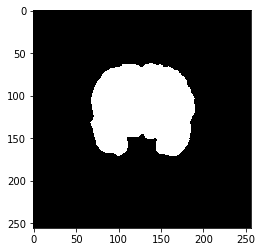

In [4]:
plt.imshow(img)

In [581]:
segments.max()

1587

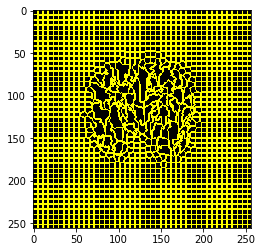

In [582]:
plt.imshow(mark_boundaries(img,segments))

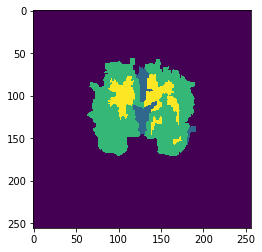

In [583]:
n_vertex = 2000
n_class = 4
f_label = np.zeros(n_vertex)

for i in range(segments.max()+1):
    h = int(np.where(segments==i)[0].mean())
    w = int(np.where(segments==i)[1].mean())
    f_label[i] = label[h, w]

label_new = np.zeros((label.shape[0], label.shape[1]))
for i in range(segments.max()+1):
    label_new[np.where(segments==i)] = f_label[i]
plt.imshow(label_new)

In [246]:
def feature_extract(img, segments, f_range=5, n_vertex=256, tao=0.1):
    step = math.floor(f_range/2)
    n_segments = np.max(segments) + 1
    centroid_list = []
    for i in range(n_vertex):
        if i < n_segments:
            h_mean = int(np.where(segments==i)[0].mean())
            w_mean = int(np.where(segments==i)[1].mean())
            centroid_list.append((h_mean, w_mean))
        else:
            h_mean = int(np.where(segments==0)[0].mean())
            w_mean = int(np.where(segments==0)[1].mean())
            centroid_list.append((h_mean, w_mean))
    
    features = np.zeros((n_vertex, f_range*f_range))
    for i in range(n_vertex):
        h, w = centroid_list[i]
        features[i] = img[h-step:h+step+1, w-step:w+step+1, 0].flatten() 
        
    aj_arr = np.zeros((n_vertex, n_vertex))
    for i in range(n_vertex):
        for j in range(n_vertex):
            diff = features[i] - features[j]
            diff = np.power(diff, 2)
#             for k in range(diff.shape[0]):
#                 diff[k] = math.pow(diff[k], 2)
            l2_norm_square = diff.sum()   
            aj_arr[i, j] = math.exp(-l2_norm_square / (2*tao*tao))
    
    return features, aj_arr

In [247]:
def back_to_label(segments, class_output):
    output = np.zeros((segments.shape[0], segments.shape[1]))
    for i in range(class_output.shape[0]):
        output[np.where(segments==i)] = class_output[i]
    return output

In [260]:
f, a = feature_extract(img, segments, 7, 300, 7)

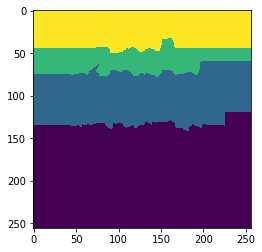

In [259]:
class_output = np.asarray([3]*50 + [2]*30 + [1]*70)
output = back_to_label(segments, class_output)
plt.imshow(output)

In [203]:
def vertex_set(img, segments, filter_size, num):
    step = math.floor(filter_size/2)
    num_of_segments = np.max(segments) + 1
    centroid_list = []
    for i in range(num_of_segments):
        h_mean = int(np.where(segments==i)[0].mean())
        w_mean = int(np.where(segments==i)[1].mean())
        val_mean = img[h_mean-step:h_mean+step+1, w_mean-step:w_mean+step+1].mean()
        centroid_list.append((h_mean, w_mean, val_mean))
        centroid_list.sort(key = itemgetter(2), reverse=True)
    
    features = np.zeros((num, filter_size*filter_size))
    for i in range(num):
        h, w, v = centroid_list[i]
        features[i] = img[h-step:h+step+1, w-step:w+step+1, 0].flatten() 
    
    return features, centroid_list

In [204]:
def adjacency_array(features, tao):
    n = features.shape[0]
    aj_arr = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            diff = features[i] - features[j]
            for k in range(diff.shape[0]):
                diff[k] = math.pow(diff[k], 2)
            l2_norm_square = diff.sum()   
            aj_arr[i, j] = math.exp(-l2_norm_square / (2*tao*tao))
    return aj_arr

In [205]:
features, centroid_list = vertex_set(img, segments, 7, 150)

In [206]:
aj_arr = adjacency_array(features, 0.5)

In [207]:
def back_to_label(segments, class_output, centroid_list):
    output = np.zeros((segments.shape[0], segments.shape[1]))
    for i in range(class_output.shape[0]):
        h = centroid_list[i][0]
        w = centroid_list[i][1]
        lab_num = segments[h, w]
        output[np.where(segments==lab_num)] = class_output[i]
    return output

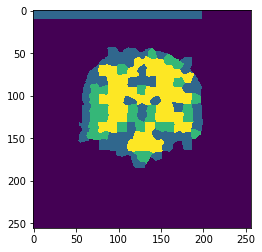

In [208]:
class_output = np.asarray([3]*50 + [2]*30 + [1]*70)
output = back_to_label(segments, class_output, centroid_list)
plt.imshow(output)

In [109]:
info = np.zeros((img.shape[0], img.shape[1], 3))
n = 7
step = math.floor(n/2)
# for c in centroid_list:
#     for i in range(c[0]-3, c[0]+3+1):
#         for j in range(c[1]-3, c[1]+3+1):
#             info[i, j, 0] = img[i, j, 0] 
#             info[i, j, 1] = img[i, j, 1] 
#             info[i, j, 2] = img[i, j, 2] 

for c in centroid_list:
    info[c[0]-step:c[0]+step+1, c[1]-step:c[1]+step+1] = img[c[0]-step:c[0]+step+1, c[1]-step:c[1]+step+1]

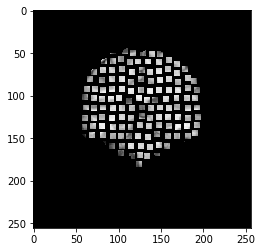

In [134]:
plt.imshow(info)

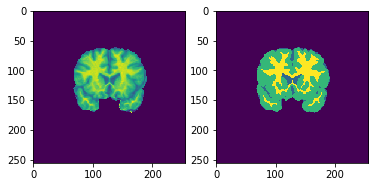

In [538]:
image = nib.load('/home/tony/Documents/IBSR_preprocessed_2d/IBSR_01/image_80.nii.gz').get_data().astype(np.float32)
label = nib.load('/home/tony/Documents/IBSR_preprocessed_2d/IBSR_01/label_80.nii.gz').get_data().astype(np.int64)
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(label)
image = max_min_normalize(image)
image = np.expand_dims(image, axis=2)

image = np.concatenate((image, image, image), 2)
segments = slic(image.astype('double'), n_segments=2000, compactness=20)

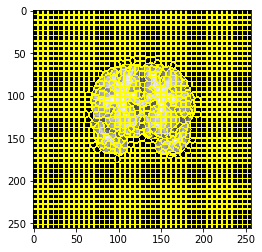

In [539]:
plt.imshow(mark_boundaries(image, segments))

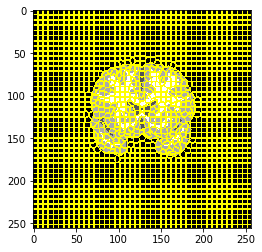

In [540]:
# transform label to feature
n_vertex = 2048
n_class = 4
f_label = np.zeros(n_vertex)

for i in range(segments.max()+1):
    h = int(np.where(segments==i)[0].mean())
    w = int(np.where(segments==i)[1].mean())
    f_label[i] = label[h, w]
    
# for i in range(segments.max()+1):
#     f_label[i] = round(label[np.where(segments==i)].mean())
    
plt.imshow(mark_boundaries(max_min_normalize(label), segments))

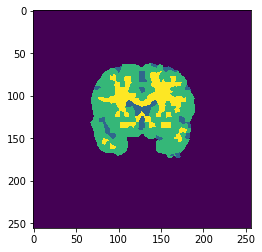

In [541]:
# turn back feature to label
label_new = np.zeros((label.shape[0], label.shape[1]))
for i in range(segments.max()+1):
    label_new[np.where(segments==i)] = f_label[i]
plt.imshow(label_new)

In [503]:
def label_transform(label, segments):
    #f_label = np.zeros(n_vertex)
    label_new = np.zeros((label.shape[0], label.shape[1]))
    for i in range(segments.max() + 1):
        where = np.where(segments==i)
        h = int(where[0].mean())
        w = int(where[1].mean())
        label_new[np.where(segments==i)]  = label[h, w] 
    return label_new

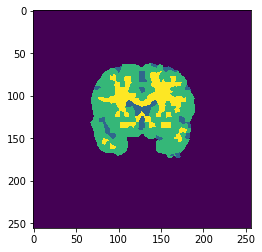

In [504]:
label_new = label_transform(label, segments)
plt.imshow(label_new)

In [405]:
import torch
a = torch.zeros(2, 2).long()
a

tensor([[0, 0],
        [0, 0]])

In [451]:
output = torch.LongTensor(f_label).cuda()
target= torch.LongTensor(label).cuda()
seg = torch.LongTensor(segments).cuda()

img = torch.zeros_like(target).long()

mask0 = torch.zeros_like(target)
mask1 = torch.ones_like(target)

# for i in range(seg_tensor.max() + 1):
#     seg_tensor = np.asarray(seg_tensor.cpu())
#     where = np.where(seg_tensor==i)
#     h = int(where[0].mean())
#     w = int(where[1].mean())
#     seg_tensor = torch.LongTensor(seg_tensor).cuda()
#     img += torch.where(seg_tensor==i, label_tensor[h, w]*mask1, mask0)

for i in range(seg_tensor.max() + 1):
    img += torch.where(seg_tensor==i, output[i]*mask1, mask0)

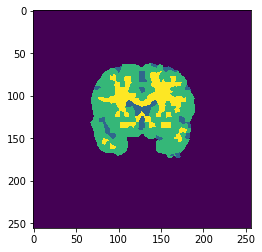

In [433]:
img = np.asarray(img.cpu())
plt.imshow(img)

In [464]:
x = torch.rand(3, 7)
x

tensor([[0.7041, 0.7984, 0.1155, 0.7155, 0.4653, 0.4735, 0.1769],
        [0.9559, 0.2194, 0.7668, 0.0571, 0.4287, 0.5186, 0.4793],
        [0.5714, 0.4119, 0.4528, 0.4247, 0.0440, 0.8828, 0.8793]])

In [493]:
a = torch.FloatTensor([[0., 0., 0., 1.],
           [1., 0., 1., 0.],
           [0., 1., 0., 1.],
           [0., 1., 0., 0.]])
i = torch.eye(a.size(0))
a_hat = a+i
a_hat

tensor([[1., 0., 0., 1.],
        [1., 1., 1., 0.],
        [0., 1., 1., 1.],
        [0., 1., 0., 1.]])

In [494]:
d = torch.diag(a_hat.sum(1))
d

tensor([[2., 0., 0., 0.],
        [0., 3., 0., 0.],
        [0., 0., 3., 0.],
        [0., 0., 0., 2.]])

In [495]:
torch.inverse(d)

tensor([[0.5000, 0.0000, 0.0000, -0.0000],
        [0.0000, 0.3333, 0.0000, -0.0000],
        [0.0000, 0.0000, 0.3333, -0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000]])

In [500]:
torch.mm(torch.inverse(d), a_hat)

tensor([[0.5000, 0.0000, 0.0000, 0.5000],
        [0.3333, 0.3333, 0.3333, 0.0000],
        [0.0000, 0.3333, 0.3333, 0.3333],
        [0.0000, 0.5000, 0.0000, 0.5000]])

In [477]:
(a.sum(1, keepdim=True) + 1)

tensor([[1.5103],
        [3.0652],
        [2.9216]])

In [476]:
e = torch.eye(3) * (a.sum(1, keepdim=True) + 1)
e

tensor([[1.5103, 0.0000, 0.0000],
        [0.0000, 3.0652, 0.0000],
        [0.0000, 0.0000, 2.9216]])

In [502]:
i = torch.eye(a.size(0))                                                                                                                                                             
a_hat = a + i
d = torch.diag(a_hat.sum(1))
adj_arr = torch.mm(torch.inverse(d), a_hat)

In [2]:
a = 5
def test_func(b):
    b += 1
    return 1
c = test_func(a)
print(a)
    

5


In [4]:
np.arange(5, 10)

array([5, 6, 7, 8, 9])